# Rozpoznanie pojedyńczej cyfry na captchy
### Zawartość notebooka
>   1. Na początku przedstawimy po krótce jak działa jupyter notebook :)
>   2. Po krótce o bibliotekach
>   3. wczytanie danych
>   4. preproccessing
>   5. w pełni konwolucyjna sieć neuronowa

### Jak działa jupyter notebook?
>Jupyter notebook jest bardzo często wykorzystywanym narzędziem. Jego najwiekszą zaletą jest możliwość wykonywania kodu po komórce na raz. Aby wykonał się kod w komórce należy nacisnąć ctrl+enter lub shift+enter aby od razu przejść do następnej komórki.

In [1]:
print('Hello!')

Hello!


Można też dodawać ładniejsze komentarze pisane w markdownie.

### Tutył
   tekst _tekst_ **tekst** ~~tekst~~

### Biblioteki
>1. Numpy - biblioteka do obliczeń numerycznych. Często używana do obsługi macierzy tzn. obrazów.
>2. keras - nasza biblioteka do sieci neuronowych
>3. matplotlib - biblioteka do robienia wykresów lub pokazywania obrazków
>4. sklearn - biblioteka do uczenia maszynowego. My użyjemy tylko jednej funkcji ale jest tam masa modeli i innych skarbów.
>5. os - system operacyjny tzn wypisanie plików w folderze

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.image import img_to_array, load_img
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Wczytanie danych
Dane ułożone są w 10 folderach o nazwach od '0' do '9'. Przeiterujemy po folderach wczytując obrazki z każdego z nich zachowując nazwę folderu jako label.

In [3]:
def load_data(path):
    # obrazki
    images = []
    # etykiety
    labels = []
    for i in range(10):
        # tworzymy ściężkę do folderu przez połączenie 
        # ścieżki do folderu z danymi z cyfra od 0 do 9
        folder_path = os.path.join(path, str(i)) 
        
        # pętla do iterowania po folderach
        for img in os.listdir(folder_path):
            
            # wczytanie obrazka
            image = load_img(os.path.join(folder_path, img))
            
            # zamiana na numpy.ndarray
            x = img_to_array(image)
            
            # średnia zamiani nam kolorowy obrazek na czarnobiały
            # normalinie robi się średnią ważoną ale nie zależy nam na wyglądzie
            x = np.mean(x, axis = 2)[:, :, np.newaxis]
            
            # dołączamy obrazek do przykładów treningowych
            images.append(x)
            labels.append(i)
            
    # shuffling
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
            
    return np.array(images)[indices], np.array(labels)[indices]

In [4]:
X, y = load_data('../data/dane/')

In [5]:
X.shape

(20000, 60, 60, 1)

In [6]:
# dzielimy dane na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
X_test.shape

(5000, 60, 60, 1)

In [8]:
class our_scaler:
    '''
        w sklearn znajduje się StandardScaler służący do normalizacji danych.
        Z jakiegoś powodu nie działał w tym przypadku dlatego napisałem swój.
        std = odchylenie standardowe
        mean = średnia
    '''
    def __init__(self):
        self.mean = 0
        self.std = 1
        
    def fit(self, data):
        self.mean = np.mean(data)
        self.std = np.std(data)
        
    def transform(self, data):
        return (data - self.mean) / self.std
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    

In [9]:
scaler = our_scaler()

# ważne jest aby normalizować obydwa zbiory tymi samymi wartościami
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# oczekujemy że odchylenia zbioru testowego będzie zbliżone do 1
np.std(X_test), np.mean(X_test)

(0.9985774, -0.00019860416)

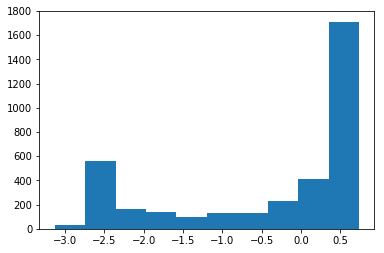

In [11]:
# wyplotujemy rozkład nasyceń pikseli losowego obrazka
plt.hist(X_train[10000].flatten())
plt.show()

Widzmy że rozkład jest bardzo nie normalny co będzie sprawiało problemy przy uczeniu sieci neuronowej.

In [12]:
np.min(X_train), np.max(X_train)

(-5.6735864, 0.804536)

Kodujemy etykiety do postaci one hot. Wektor one-hot jest n wymiarowym wektorem składającym się z samych zer i jednej jedynki. Długość wektora jest równa ilości różnych etykiet. 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

In [13]:
one_hot_targets = np.eye(10)[y_train]

In [14]:
print(y_train[:5])
print(one_hot_targets[:5])

[5 1 1 4 8]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### Sieć neuronowa
Zbudujemy w pełni konwolucyjną sieć neuronową. W klasycznej sieci neuronowej, na końcu, znajduje się szereg warstw w pełni połączonych. W naszym przypadku warstwy w pełni połączone zostaną zastąpione konwolucjami 1x1 ma to szereg właściwości które bedą porządane w dalszej części.

Ten model będzie się prawdopodobnie długo uczył na procesorze (ok. 30 min) dlatego w komórce niżej wczytujemy juz przeuczony przeze mnie model ;)

#### Tworzenie modeli w kerasie
Jest na świecie mało rzeczy łatwiejszych od stworzenia sieci neuronowej w kerasie. Jest to biblioteka stworzona do bezwysiłkowego tworzenia prostych modeli. Do naszych potrzeb będziemy potrzebowali modelu sekwencyjnego Sequential który kieruje wyjście poprzedniej warstwy na wejście następnej. So modelu dodajemy wartswy metodą .add po koleji.

In [18]:
# model sekwencyjny czyli wyjście z 
# warstwy poprzedniej jest kierowane do następnej
model = keras.models.Sequential()

# dodanie warstwy do modelu. W tym przypadku jest to warstwa konwolucyjna z 32 filtrami rozmiaru 5x5. 
# Ze względu na rozkład nasycenia pikseli funckją altywacji jest elu zamist relu. Zmniejsza to ilość martwych neuronów.
# input_shape jest wielkości (None, None, 1) ponieważ None dane nam mozliwość wrzucenia do sieci większego obrazka.
model.add(keras.layers.Conv2D(32, kernel_size = (5, 5), activation = 'elu', input_shape = (None, None, 1)))
model.add(keras.layers.Conv2D(64, kernel_size = (5, 5), activation = 'elu'))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'elu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(64, kernel_size = (5, 5), activation = 'elu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'elu'))

#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'elu'))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.MaxPool2D())

model.add(keras.layers.Conv2D(128, kernel_size = (1, 1), activation = 'elu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(10, kernel_size=(1,1)))

# Global max pooling bierze macierz wektorów aktywacji po czym maxuje względem macierzy (wytłumaczę live :)) )
model.add(keras.layers.GlobalAveragePooling2D())

model.add(keras.layers.Softmax())
#model.add(keras.layers.Lambda(lambda x: K.clip(x, 1e-4, 0.999)))

model.compile(keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-5), 
              'categorical_crossentropy',
             metrics = [keras.metrics.categorical_accuracy])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    51264     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
__________

In [20]:
model.fit(X_train, one_hot_targets, epochs = 8, batch_size = 16, shuffle = True, validation_split = 0.15, callbacks = [keras.callbacks.TerminateOnNaN()])

Train on 12750 samples, validate on 2250 samples
Epoch 1/8
12750/12750 [==============================] - 18s 1ms/step - loss: 0.7591 - categorical_accuracy: 0.7323 - val_loss: 0.1750 - val_categorical_accuracy: 0.9467
Epoch 2/8
12750/12750 [==============================] - 11s 876us/step - loss: 0.1580 - categorical_accuracy: 0.9484 - val_loss: 0.1407 - val_categorical_accuracy: 0.9573
Epoch 3/8
12750/12750 [==============================] - 11s 892us/step - loss: 0.0949 - categorical_accuracy: 0.9713 - val_loss: 0.1051 - val_categorical_accuracy: 0.9622
Epoch 4/8
12750/12750 [==============================] - 12s 942us/step - loss: 0.0875 - categorical_accuracy: 0.9743 - val_loss: 0.0647 - val_categorical_accuracy: 0.9804
Epoch 5/8
12750/12750 [==============================] - 11s 866us/step - loss: 0.0584 - categorical_accuracy: 0.9821 - val_loss: 0.0474 - val_categorical_accuracy: 0.9844
Epoch 6/8
12750/12750 [==============================] - 11s 886us/step - loss: 0.0768 - cate

In [15]:
#model.save('model_1_pretrained.h5')

NameError: name 'model' is not defined

In [48]:

model_path = './model_1_pretrained.h5'
model = keras.models.load_model(model_path)

wyjście modelu:  [[1.4485910e-08 2.2772707e-13 4.6380713e-09 1.0970067e-09 9.9998999e-01
  1.0358443e-11 6.7930978e-10 6.9540290e-11 1.0046694e-05 7.5192341e-09]]
argmax: 	 4
GT: 		 4


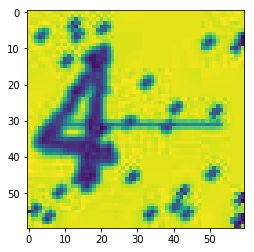

wyjście modelu:  [[2.4394701e-15 1.7830319e-16 1.2125171e-17 1.6285975e-10 8.4556368e-17
  6.6540023e-10 5.3261045e-20 2.9707821e-15 1.5500384e-12 1.0000000e+00]]
argmax: 	 9
GT: 		 9


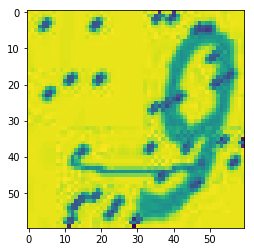

wyjście modelu:  [[2.33925952e-04 2.80893910e-05 1.33056155e-05 1.16219917e-14
  5.68255998e-10 9.45590503e-13 8.58283149e-12 9.99724567e-01
  5.66967046e-12 1.66072456e-09]]
argmax: 	 7
GT: 		 7


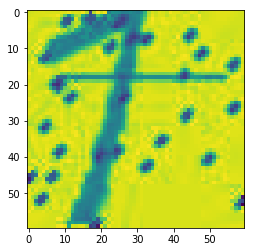

In [17]:
for i in range(3):
    plt.imshow(np.squeeze(X_test[110 + i]))
    preds = model.predict(X_test[110 + i][np.newaxis, :, :, :])
    print('wyjście modelu: ', preds)
    print('argmax: \t', np.argmax(preds))
    print('GT: \t\t', y_test[110 + i])
    plt.show()

In [18]:
test_preds = model.predict(X_test)
test_preds = [np.argmax(t) for t in test_preds]

In [19]:
test_preds[:5]

[2, 2, 8, 1, 4]

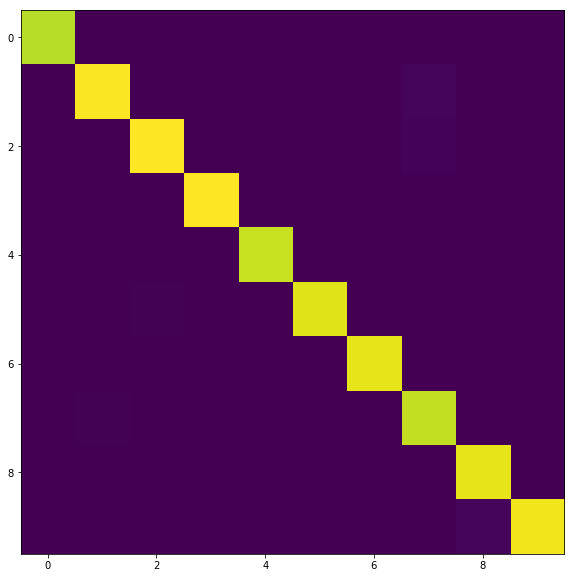

In [20]:
plt.figure(figsize = (10, 10))
plt.imshow(confusion_matrix(y_true = y_test, y_pred = test_preds))
plt.show()

In [21]:
model2 = keras.models.Model(inputs = [model.input], outputs = [model.layers[-3].output])

Sprawdźmy co teraz wychodzi z modelu

In [22]:
test = model2.predict(X_train[2:3])

In [23]:
test.shape 

(1, 8, 8, 10)

In [24]:
np.max(test)

197.75153

In [25]:
test.shape

(1, 8, 8, 10)

In [104]:
def show_egz_softmax(num):
    def soft(vec):
        return np.exp(vec/40)/np.sum(np.exp(vec/40))
    
    
    output_tensor = model2.predict(X_test[num:num+1])
    output_tensor = np.apply_along_axis(soft, 3, test)
    plt.imshow(np.squeeze(X_test[num]))
    plt.show()
    plt.figure(figsize = (10, 10))
    for i in range(1, 10):

        plt.subplot(3, 3, i)
        plt.title(str(i), size = 20)
        plt.imshow(np.squeeze(output_tensor[:, :, :, i]), vmin = 0, vmax = 1)
    plt.show()

(1, 8, 8, 10)


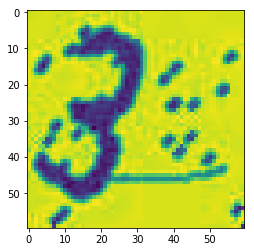

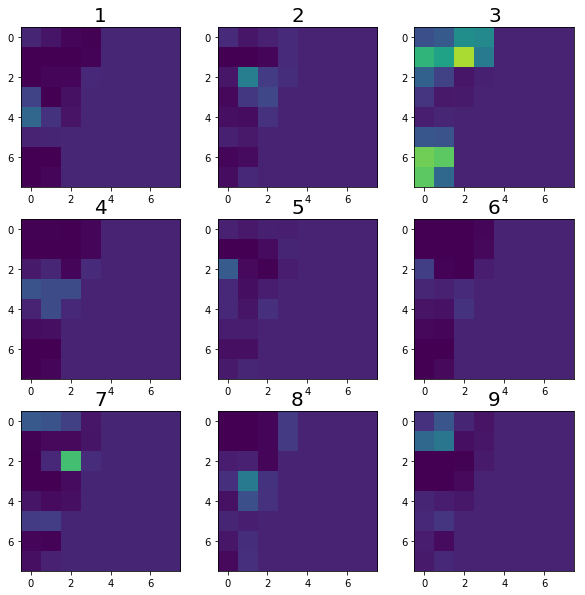

In [105]:
show_egz_softmax(134)

In [28]:
def softmax_np(arr):
    return np.exp(arr/40)/np.sum(np.exp(arr/40))

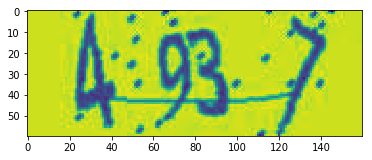

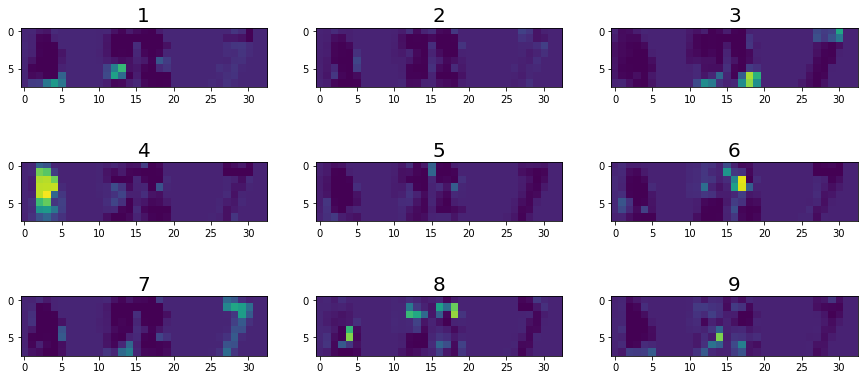

In [30]:
arr = np.array(load_img('./captcha_4/1.jpg'))
arr = np.mean(arr, axis = 2)
arr = scaler.transform(arr)
plt.imshow(arr)
plt.show()
output_tensor = model2.predict(arr[:, :, np.newaxis][np.newaxis, :, :, :])

output_tensor_softmax = np.apply_along_axis(softmax_np, 3, test3)

plt.figure(figsize = (15, 7))
for i in range(1, 10):

    plt.subplot(3, 3, i)
    plt.title(str(i), size = 20)
    plt.imshow(np.squeeze(output_tensor_softmax[:, :, :, i]), vmin = 0, vmax = 1)

plt.show()

In [31]:
output_tensor.shape

(1, 8, 33, 10)

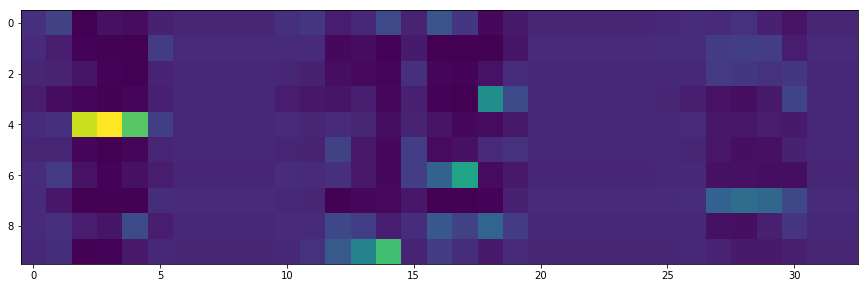

In [32]:
plt.figure(figsize = (15, 8))
plt.imshow(np.apply_along_axis(softmax_np, 0, np.transpose(np.squeeze(np.mean(output_tensor, axis = 1)))))
plt.show()

***
***
***

## Teraz, kiedy już model działa, zrobimy tak żeby nie działał
Spróbujemy zmodyfikować obrazek tak żeby nasz model nie był w stanie go rozpoznać

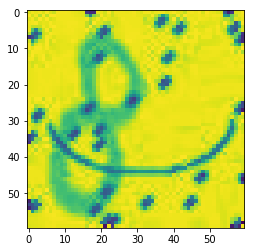

In [79]:
import foolbox
from foolbox.criteria import TargetClassProbability
X_test[4].shape
plt.imshow(np.squeeze(X_train[4]))
plt.show()

In [106]:
np.argmax(model.predict(X_train[4][np.newaxis, :, :, :]))

8

In [95]:
fmodel = foolbox.models.KerasModel(model, bounds = (-6., 1.))
attack = foolbox.attacks.L2BasicIterativeAttack(fmodel) 
adversarial = attack(X_train[4], y_train[4])

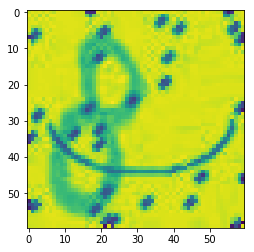

In [96]:
plt.imshow(np.squeeze(adversarial))

In [97]:
np.argmax(model.predict(adversarial[np.newaxis, :, :, :]))

0

0.32951343

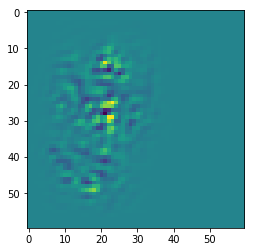

In [101]:
plt.imshow(np.squeeze(adversarial) - np.squeeze(X_train[4]))
np.max(np.squeeze(adversarial) - np.squeeze(X_train[4]))